In [28]:
! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.22) to /tmp/pip-install-2l8h6yu6/granite-tsfm_e2fd06b106344d6881c1d15eb651c432
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-2l8h6yu6/granite-tsfm_e2fd06b106344d6881c1d15eb651c432
  Running command git checkout -q 216850d0cb073e31689049c1334f701fe11bc2c3
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 216850d0cb073e31689049c1334f701fe11bc2c3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [29]:
import math
import os
import tempfile

import pandas as pd
import numpy as np
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

from sklearn.preprocessing import LabelEncoder

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [30]:
os.listdir()

['.config',
 'training_dataset.csv',
 'ttm_finetuned_models',
 'testing_dataset.csv',
 'sample_data']

In [31]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# TTM Model path. The default model path is Granite-R2. Below, you can choose other TTM releases.
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"
# TTM_MODEL_PATH = "ibm-research/ttm-research-r2"

# Context length, Or Length of the history.
# Currently supported values are: 512/1024/1536 for Granite-TTM-R2 and Research-Use-TTM-R2, and 512/1024 for Granite-TTM-R1
CONTEXT_LENGTH = 512

# Granite-TTM-R2 supports forecast length upto 720 and Granite-TTM-R1 supports forecast length upto 96
PREDICTION_LENGTH = 96

TARGET_DATASET = "etth1"
dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"


# Results dir
OUT_DIR = "ttm_finetuned_models/"

label_encoder = LabelEncoder()

In [32]:
# Dataset
TARGET_DATASET = "datavidia"
dataset_path = "./training_dataset.csv"
test_dataset_path = "./testing_dataset.csv"
timestamp_column = "Date"
id_columns = ['commodity', 'province']
target_columns = ['price']
split_config = {
    "train": [0, 8640],
    "valid": [8640, 11520],
    "test": [
        11520,
        14400,
    ],
}
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

test_data = pd.read_csv(
    test_dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

In [33]:
def process_dataset(df: pd.DataFrame):
    df['Date'] = pd.to_datetime(df['Date'])
    df['timestamp'] = df['Date'].astype(int)
    df['timestamp'] = df['timestamp'].div(10**9)

    df['province'] = label_encoder.fit_transform(df['province'])
    df['commodity'] = label_encoder.fit_transform(df['commodity'])

    df = df.drop(columns=['Unnamed: 0'])
    return df

In [34]:
data = process_dataset(data)

In [35]:
data.head()

,Date,commodity,province,price,GlobalOpen,GlobalHigh,GlobalLow,GlobalVol.,GlobalChange %,GlobalPrice,CE_Close,CE_High,CE_Low,CE_Open,timestamp
0,2022-01-01,0,0,28970.0,205.9048,782.25,3.5,228640.0,-0.48,202.7536,3554.002863,14301.299805,0.029976,3561.752985,1.640995e+09
1,2022-01-01,1,0,27440.0,205.9048,782.25,3.5,228640.0,-0.48,202.7536,3554.002863,14301.299805,0.029976,3561.752985,1.640995e+09
2,2022-01-01,2,0,11030.0,205.9048,782.25,3.5,228640.0,-0.48,202.7536,3554.002863,14301.299805,0.029976,3561.752985,1.640995e+09
3,2022-01-01,3,0,12080.0,205.9048,782.25,3.5,228640.0,-0.48,202.7536,3554.002863,14301.299805,0.029976,3561.752985,1.640995e+09
4,2022-01-01,4,0,22360.0,205.9048,782.25,3.5,228640.0,-0.48,202.7536,3554.002863,14301.299805,0.029976,3561.752985,1.640995e+09


In [36]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=5,
    freeze_backbone=True,
    num_epochs=50,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    dset_train, dset_val, dset_test = get_datasets(
        tsp, data, fewshot_fraction=fewshot_percent / 100, fewshot_location="first"
    )

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

-------------------- Running few-shot 5% --------------------


INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:[TTM] context_length = 512, prediction_length = 96


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.645100,0.793684
2,0.522700,0.823432
3,0.437100,0.855638
4,0.380400,0.904329
5,0.371300,0.902364


[TrackingCallback] Mean Epoch Time = 1.3830253601074218 seconds, Total Train Time = 14.353548765182495
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.8663141131401062, 'eval_runtime': 23.067, 'eval_samples_per_second': 1559.458, 'eval_steps_per_second': 48.771, 'epoch': 5.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
PredictionOutput(predictions=(array([[[0.72974247],
        [0.7307035 ],
        [0.747792  ],
        ...,
        [0.8827816 ],
        [0.9094215 ],
        [0.8756922 ]],

       [[0.7477273 ],
        [0.7615135 ],
        [0.7837558 ],
        ...,
        [0.9283091 ],
        [0.93125415],
        [0.8980727 ]],

       [[0.78202   ],
        [0.79404384],
        [0.81421185],
        ...,
        [0.9300745 ],
        [0.9336092 ],
        [0.9077619 ]],

       ...,

       [[0.8527868 ],
        [0.83298975],
        [0.8216899 ],
        ...,
        [0.81447595],
        [0.79873496],
        [0.78977185]],

       [[0.8060264 ],
        [0.80567557],
        [0.8013556 ],
        ...,
        [0.7585771 ],
        [0.7569175 ],
        [0.7765966 ]],

       [[0.81610155

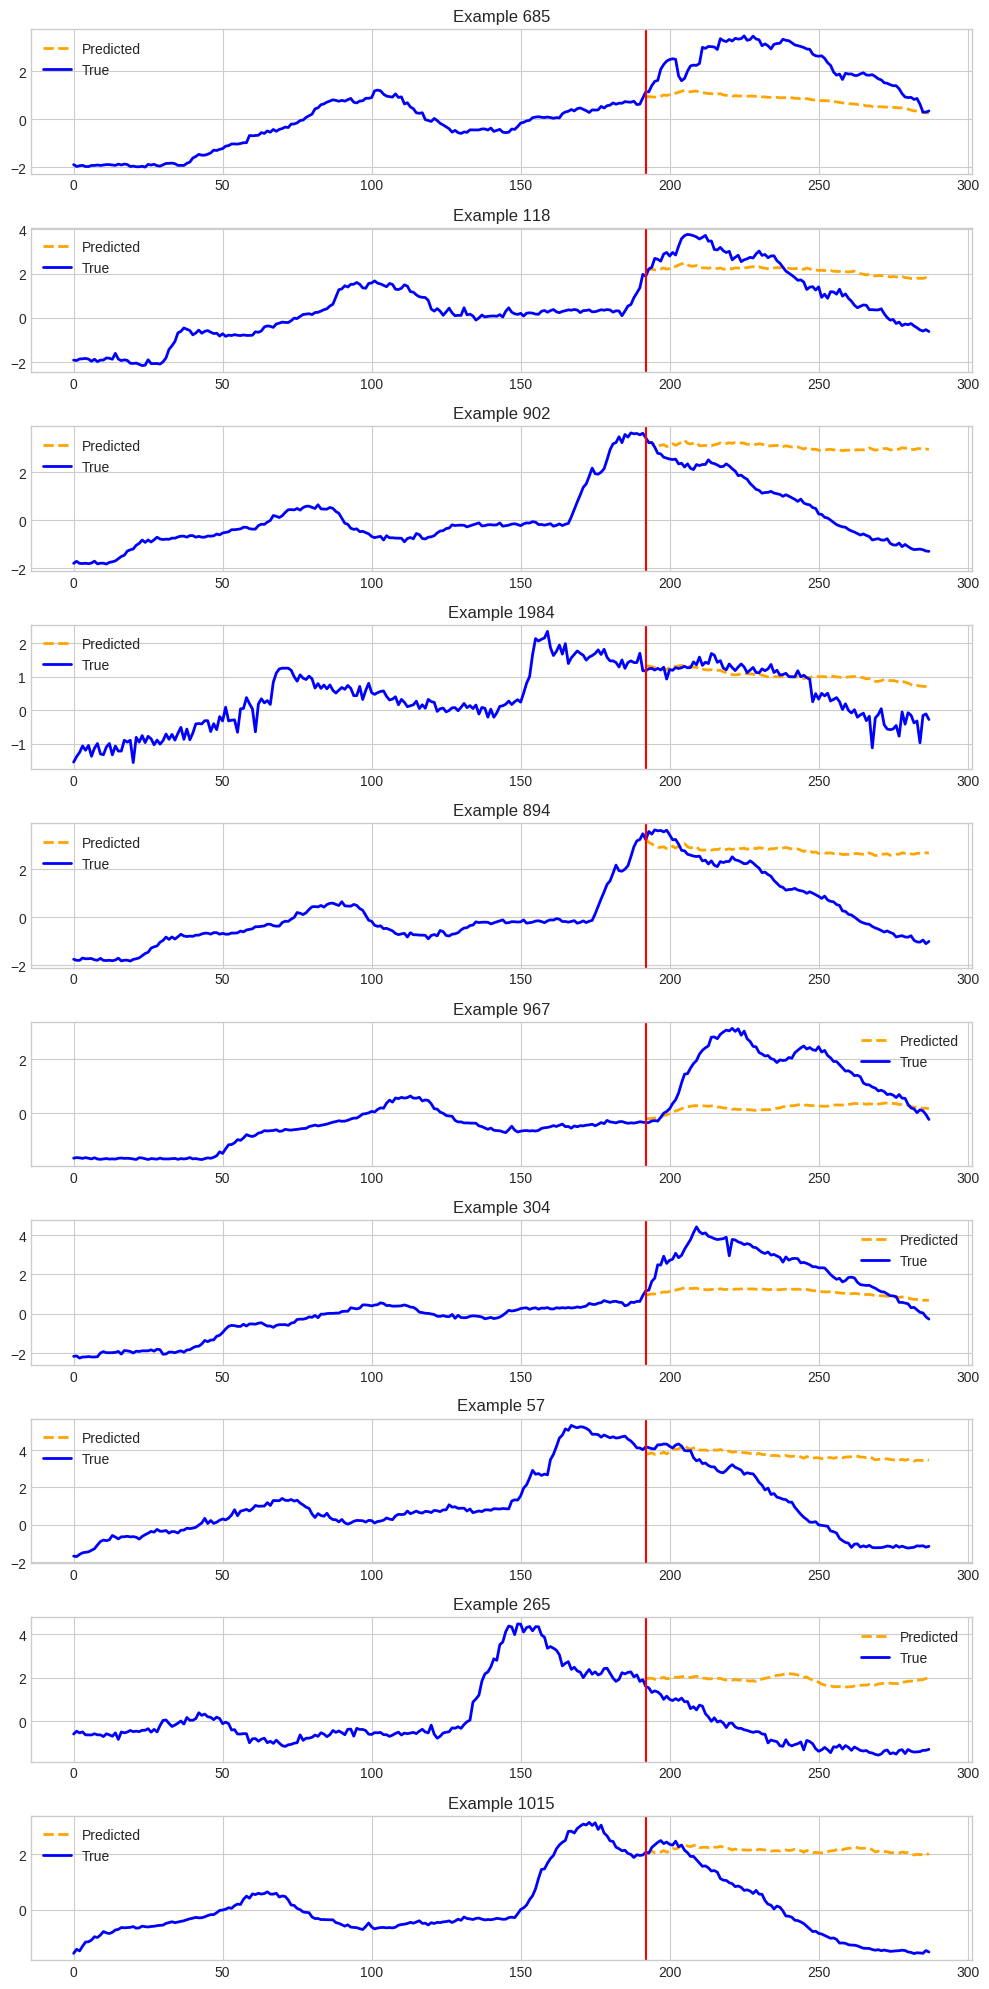

In [37]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=32,
    fewshot_percent=5,
    learning_rate=0.001,
    num_epochs=5
)